# Querying Splunk Data From a Notepad

## Installing and Importing the Splunk SDK

In [47]:
!pip install splunk-sdk

import splunklib.results as results
import splunklib.client as client

## Import Libraries

In [48]:
# Base 
import io, os, sys, types, datetime, math, StringIO, time

# Data Manipulation
import random
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
!pip install missingno
import missingno
import seaborn as sns

# Feature Selection and Encoding
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Connection Details for your Splunk instance - TO EDIT

In [49]:
# Your Splunk Instance
HOST = "splunk"
PORT = 8089
USERNAME = "admin"
# Update the password in Splunk and edit here as necessary
PASSWORD = "changeme"

## Connecting to Splunk Instance

In [50]:
# Create a Service instance and Attempt Connection to Splunk
try:
    service = client.connect(host=HOST, port=PORT, username=USERNAME, password=PASSWORD)
    print "Connection Successful"
except Exception,e: print str(e)

Login failed.


## Defining a Function to Query Splunk and Display Search Progress

In [51]:
# Function to Perform a Splunk search
def execute_query(searchquery_normal, 
                  kwargs_normalsearch={"exec_mode": "normal"}, 
                  kwargs_options={"output_mode": "csv", "count": 100000}):
    # Execute Search
    job = service.jobs.create(searchquery_normal, **kwargs_normalsearch)

    # A normal search returns the job's SID right away, so we need to poll for completion
    while True:
        while not job.is_ready():
            pass
        stats = {"isDone": job["isDone"], "doneProgress": float(job["doneProgress"])*100, 
                 "scanCount": int(job["scanCount"]), "eventCount": int(job["eventCount"]), 
                 "resultCount": int(job["resultCount"])}
        status = ("\r%(doneProgress)03.1f%%   %(scanCount)d scanned   " 
                  "%(eventCount)d matched   %(resultCount)d results") % stats

        sys.stdout.write(status)
        sys.stdout.flush()
        if stats["isDone"] == "1":
            sys.stdout.write("\nDone!")
            break
        time.sleep(0.5)

    # Get the results and display them
    csv_results = job.results(**kwargs_options).read()
    job.cancel()
    return csv_results

## Defining and Running a Splunk Search

In [52]:
splunk_query = """
search index=_internal earliest=-4w latest=now source=*metrics.log*
| table average_kbps, component, ev, group, host, inst*, load*, log*, name, _time
""" 

In [53]:
csv_results = execute_query(splunk_query)

100.0%   908 scanned   908 matched   908 results
Done!

In [54]:
csv_results_pandas = pd.read_csv(StringIO.StringIO(csv_results), encoding='utf8', sep=',', low_memory=False)

## Storing and Displaying the Results in/from a Pandas Dataframe

In [55]:
type(csv_results_pandas), csv_results_pandas.shape

(pandas.core.frame.DataFrame, (908, 11))

In [56]:
csv_results_pandas.head(3)

,average_kbps,component,ev,group,host,instantaneous_eps,instantaneous_kbps,load_average,log_level,name,_time
0,1.183330,Metrics,92.0,thruput,splunk,2.967699,0.779884,0.09,INFO,thruput,2017-07-21T06:07:13.629+00:00
1,0.000000,Metrics,0.0,thruput,splunk,0.000000,0.000000,NaN,INFO,syslog_output,2017-07-21T06:07:13.629+00:00
2,1.180679,Metrics,78.0,thruput,splunk,2.516093,0.779884,NaN,INFO,index_thruput,2017-07-21T06:07:13.629+00:00


In [57]:
csv_results_pandas.describe()

,average_kbps,ev,instantaneous_eps,instantaneous_kbps,load_average
count,36.000000,203.000000,36.000000,36.000000,12.000000
mean,1.126993,61.423645,3.612268,0.797828,0.241667
std,0.927401,104.286533,4.941300,0.799692,0.164970
min,0.000000,0.000000,0.000000,0.000000,0.030000
25%,0.000000,6.000000,0.000000,0.000000,0.090000
50%,1.297546,15.000000,2.709728,0.779777,0.230000
75%,1.642145,81.500000,4.024239,1.117219,0.372500
max,3.178413,669.000000,21.535976,3.183412,0.480000


In [58]:
csv_results_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 11 columns):
average_kbps          36 non-null float64
component             908 non-null object
ev                    203 non-null float64
group                 904 non-null object
host                  908 non-null object
instantaneous_eps     36 non-null float64
instantaneous_kbps    36 non-null float64
load_average          12 non-null float64
log_level             908 non-null object
name                  671 non-null object
_time                 908 non-null object
dtypes: float64(5), object(6)
memory usage: 78.1+ KB


## Displaying the Size of the Dataframe in Memory

In [59]:
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("Bytes", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])
convert_size(csv_results_pandas.memory_usage().sum())

'78.1 KB'

## Changing the Name of the Variable containing the data

In [60]:
joint_df = csv_results_pandas

## How many missing values in our dataset?

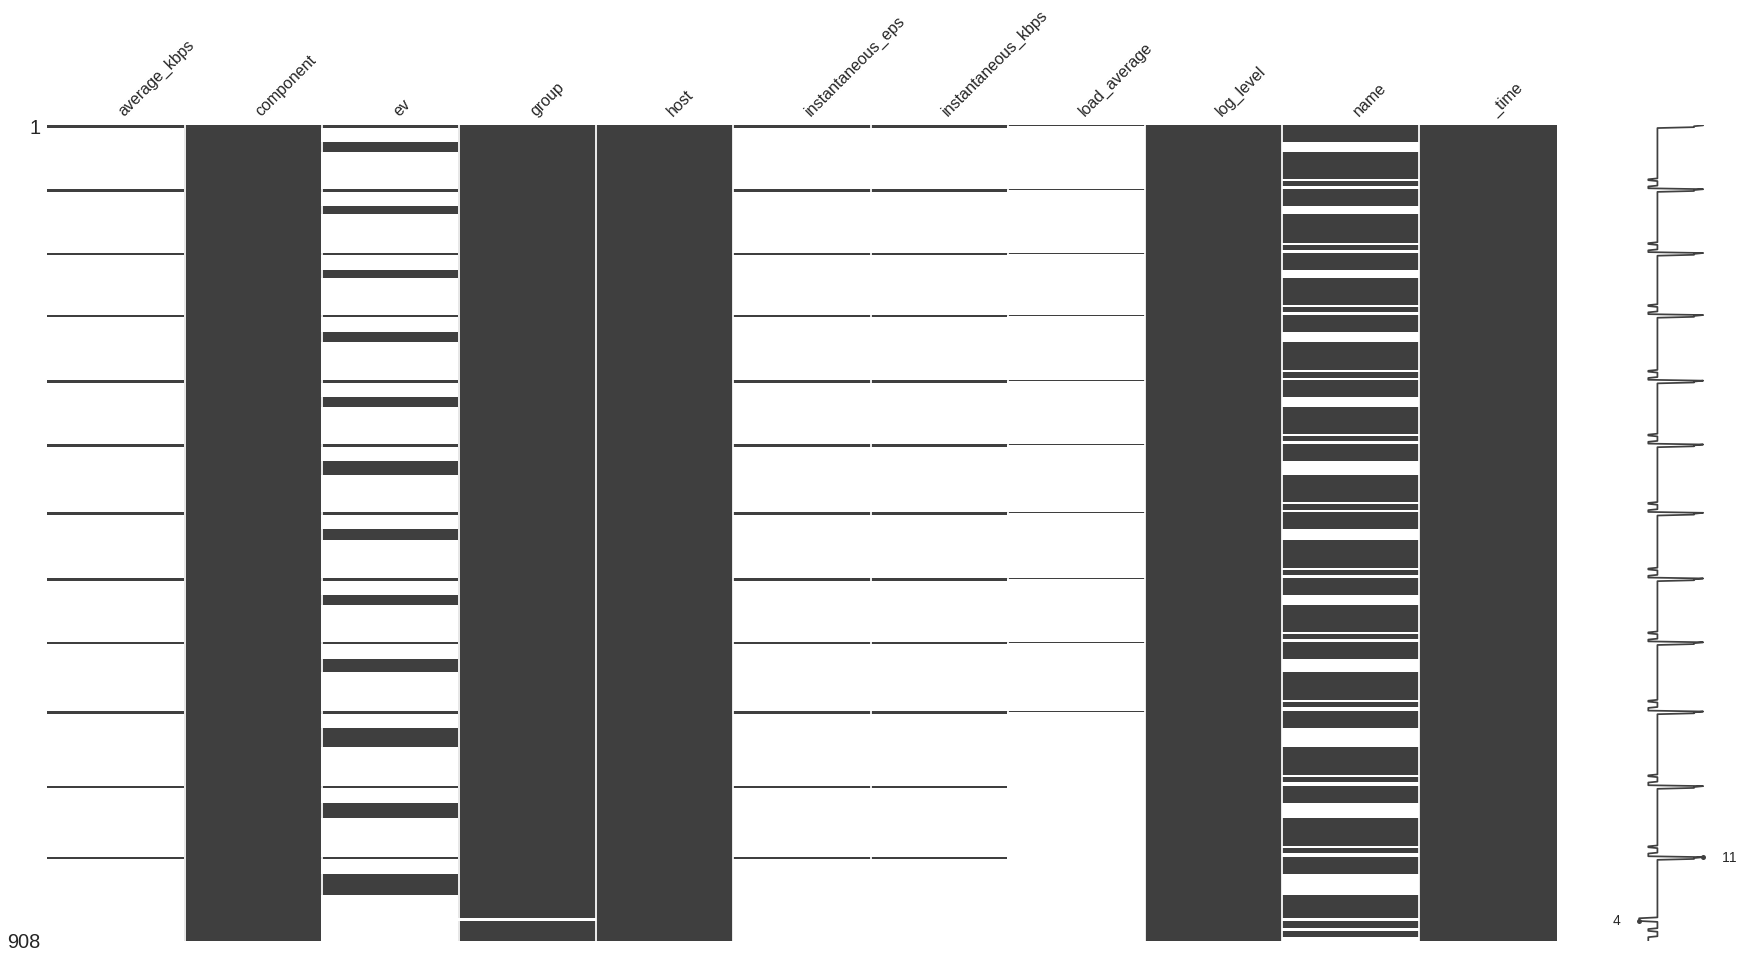

In [61]:
missingno.matrix(joint_df, figsize = (30,15));

## Let's Eliminate Fields with Missing Values From Our Original Search

In [62]:
splunk_query = """
search index=_internal earliest=-4w latest=now source=*metrics.log* average_kbps=* load_average=* 
| table average_kbps, ev, inst*, load*, _time
""" 
joint_df = execute_query(splunk_query)
joint_df = pd.read_csv(StringIO.StringIO(joint_df), encoding='utf8', sep=',', low_memory=False)

100.0%   908 scanned   12 matched   12 results
Done!

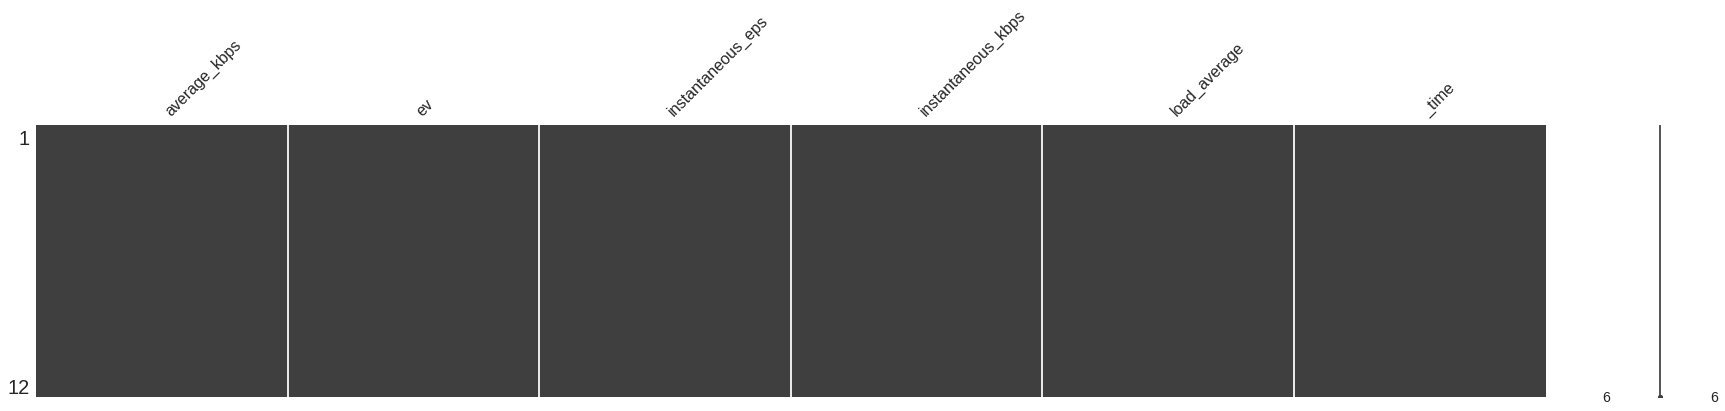

In [63]:
missingno.matrix(joint_df, figsize = (30,5));

## Print the Distribution of Each Feature

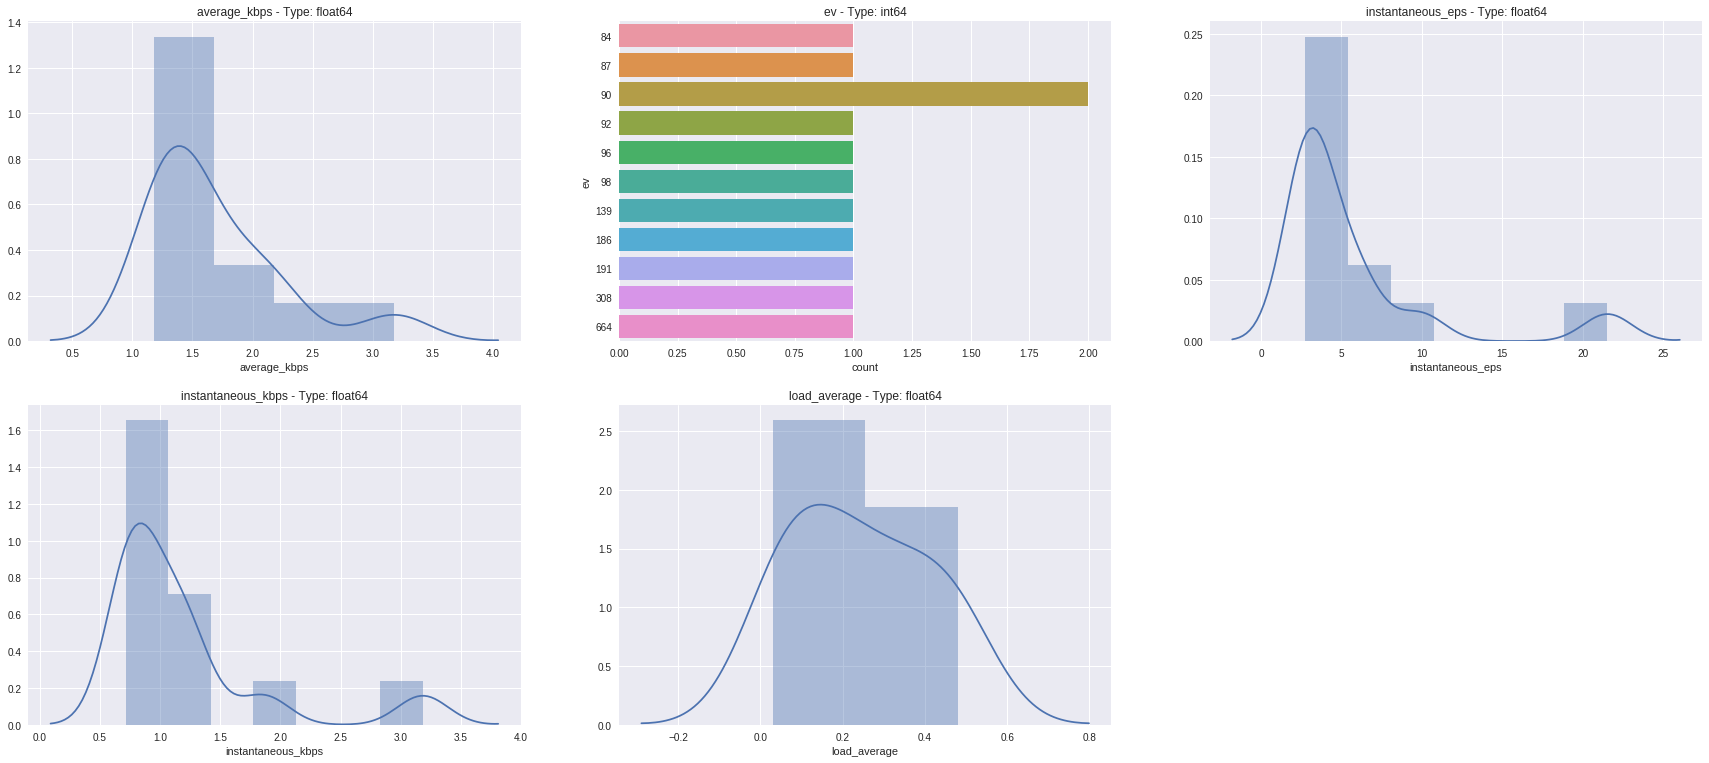

In [64]:
def plot_all(joint_df):
    
    fig = plt.figure(figsize=(30, 20)) 
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
    for feature in joint_df.columns:
        num_features = len(joint_df.columns)
        num_features = num_features if num_features%2 == 0 else num_features+1
        current_feature = joint_df.columns.get_loc(feature)
        x_pos_graph = current_feature%num_features/3
        y_pos_graph = current_feature%3

        if joint_df[feature].dtype == np.object:
            plt.subplot2grid((num_features/2,3),(x_pos_graph,y_pos_graph))
            sns.countplot(y=feature, data=joint_df);
            plt.title(feature + ' - Type: ' + str(joint_df[feature].dtype))
        elif joint_df[feature].dtype == np.float64:
            plt.subplot2grid((num_features/2,3),(x_pos_graph,y_pos_graph))
            sns.distplot(joint_df[feature]);
            plt.title(feature + ' - Type: ' + str(joint_df[feature].dtype))
        elif joint_df[feature].dtype == np.int64:
            plt.subplot2grid((num_features/2,3),(x_pos_graph,y_pos_graph))
            sns.countplot(y=feature, data=joint_df);
            plt.title(feature + ' - Type: ' + str(joint_df[feature].dtype))

if len(joint_df) > 10000:    
    plot_all(joint_df.sample(n=10000).drop(['_time'], axis=1))
else:
    plot_all(joint_df.drop(['_time'], axis=1))